## Submission 3: Relevance of Latent Space
Trains CNN autoencoders to denoise pneumonia images based on [Medical image denoising using convolutional denoising autoencoders](https://arxiv.org/pdf/1608.04667.pdf). Contains 3 CNN autoencoders:
1. Autoencoder for denoising noisy images with lambda = 25
2. Autoencoder for denoising noisy images with lambda = 50
3. Autoencoder for denoising noisy images with lambda = 75

### Import Libraries

In [63]:
from sklearn.model_selection import train_test_split
import os
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchvision.transforms.functional import to_tensor
import pandas as pd
from io import StringIO
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
from PIL import Image
import torch
from matplotlib import pyplot as plt
from skimage.util import random_noise
import numpy as np

### Load Dataset

In [64]:
original_ds_path = r"datasets/pneumonia"
original_ds_filenames = os.listdir(original_ds_path)
# print(original_ds_filenames)

In [127]:
# Dataset of clean (no noise) pneumonia images
class CleanDataset(Dataset):
    def __init__(self, img_dir):
        self.img_dir = img_dir
        self.img_labels = pd.DataFrame([filename for filename in original_ds_filenames])

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Generate image filepath
        filename = self.img_labels.iloc[idx, 0]
        img_path = self.img_dir + "/" + filename
        
        # Read image and label/filename
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx]
        return image, label

In [128]:
# Dataset of orig pneumonia images
class OrigDataset(Dataset):
    def __init__(self, img_dir, filenames):
        self.img_dir = img_dir
        self.filenames = filenames
        self.preprocessing = transforms.Compose([
            transforms.Resize((64, 64)),  # Resize images to 64x64
            transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Generate image filepath
        filename = self.filenames.iloc[idx, 0]
        img_path = self.img_dir + "/" + filename

        # Read image and label/filename
        clean_img = Image.open(img_path)

        # Apply preprocessing in DAE paper
        clean_img = self.preprocessing(clean_img)

        # Add noise
        to_tensor = transforms.PILToTensor() 
        clean_img_tensor = to_tensor(clean_img).float()
        
        return clean_img_tensor, filename

In [129]:
# # Define transform
# transform = transforms.Compose([
#     transforms.Resize((64, 64)),
#     transforms.PILToTensor()
# ])

original_ds = CleanDataset(img_dir=original_ds_path)
orig_ds = OrigDataset(img_dir = original_ds_path,
                      filenames = original_ds.img_labels)

# # Define dataloader
# orig_dataloader = DataLoader(dataset=original_ds,
#                               batch_size=64, 
#                               shuffle=False)


In [130]:
# Get indices to split data into 80% training and 20% test data
train_filenames, test_filenames = train_test_split(original_ds_filenames, train_size=0.8, random_state=0)

# Generate training and test sets from indices
train_ds = Subset(original_ds, train_filenames)
test_ds = Subset(original_ds, test_filenames)

print(f"Training samples: {len(train_ds)} ({len(train_ds)/len(original_ds)*100}% of data)")
print(f"Test samples: {len(test_ds)} ({len(test_ds)/len(original_ds)*100}% of data)")

Training samples: 1850 (79.98270644185041% of data)
Test samples: 463 (20.01729355814959% of data)


### Generating Noisy Images

In [131]:
# Dataset of noisy pneumonia images
class NoisyDataset(Dataset):
    def __init__(self, img_dir, filenames, noise_lambda):
        self.img_dir = img_dir
        self.filenames = filenames
        self.noise_lambda = noise_lambda
        self.preprocessing = transforms.Compose([
            transforms.Resize((64, 64)),  # Resize images to 64x64
            transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Generate image filepath
        filename = self.filenames.iloc[idx, 0]
        img_path = self.img_dir + "/" + filename

        # Read image and label/filename
        clean_img = Image.open(img_path)

        # Apply preprocessing in DAE paper
        clean_img = self.preprocessing(clean_img)

        # Add noise
        to_tensor = transforms.PILToTensor() 
        clean_img_tensor = to_tensor(clean_img).float()

        noise = np.random.poisson(lam=self.noise_lambda, size=clean_img_tensor.shape).astype(np.float32)
        noisy_img_tensor = clean_img_tensor + torch.from_numpy(noise)

        noisy_img_tensor = torch.clamp(noisy_img_tensor, 0, 255)
        
        return noisy_img_tensor, clean_img_tensor

In [132]:
class NoisyDatasetRGB(Dataset):
    def __init__(self, img_dir, filenames, noise_lambda):
        self.img_dir = img_dir
        self.filenames = filenames
        self.noise_lambda = noise_lambda
        self.preprocessing = transforms.Compose([
            transforms.Resize((64, 64)),  # Resize images to 64x64
            # transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Generate image filepath
        filename = self.filenames.iloc[idx, 0]
        img_path = self.img_dir + "/" + filename

        # Read image and label/filename
        clean_img = Image.open(img_path)

        # Apply preprocessing in DAE paper
        clean_img = self.preprocessing(clean_img)

        # Add noise
        to_tensor = transforms.PILToTensor() 
        clean_img_tensor = to_tensor(clean_img).float()

        noise = np.random.poisson(lam=self.noise_lambda, size=clean_img_tensor.shape).astype(np.float32)
        noisy_img_tensor = clean_img_tensor + torch.from_numpy(noise)

        noisy_img_tensor = torch.clamp(noisy_img_tensor, 0, 255)
        
        return noisy_img_tensor, clean_img_tensor

In [137]:
notactuallynoisy_ds = NoisyDataset(img_dir = original_ds_path,
                          filenames = original_ds.img_labels,
                          noise_lambda = 0)

In [146]:
loader = DataLoader(notactuallynoisy_ds, batch_size=64)


torch.Size([1, 64, 64])
With Noise (Left) vs Without Noise (Right) in noisy dataset with lambda = 75


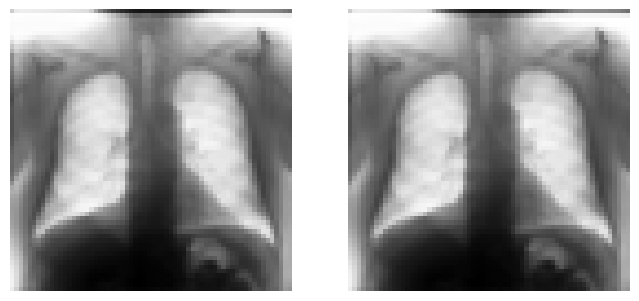

In [147]:
# Display images with and without noise
noisy_imgs, clean_imgs = next(iter(loader))

print(noisy_imgs[0].size())

noisy_img = torch.reshape(noisy_imgs[0], (64, 64, 1))
clean_img = torch.reshape(clean_imgs[0], (64, 64, 1))

imgs = [noisy_img, clean_img]

figure = plt.figure(figsize=(8, 8))
cols, rows = 2, 1
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(imgs[i-1].squeeze(), cmap="Greys")

print("With Noise (Left) vs Without Noise (Right) in noisy dataset with lambda = 75")
plt.show()

### Training CNN Autoencoders

1. Create a method called "encode" in your autoencoder model that accepts the same x (your image) but returns the the z latent space of the model. This is expected to run after you have trained the model for denoising.

In [174]:
# Model
import torch
import torch.nn as nn
import torch.optim as optim

class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # Example for grayscale images, change channels accordingly
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Use sigmoid for [0,1] scaled images
        )
        # ReLU
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        z = self.encoder(x)
        z = self.relu(z)
        return z

In [175]:
# Train Model Func
def train_model(model, dataloader, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

In [176]:
# Train Model
from torch.utils.data import DataLoader

# Example for one set, repeat for each noise level dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

model = CNNAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
dataloader = DataLoader(notactuallynoisy_ds, batch_size=64, shuffle=False)

# Train each model
train_model(model, dataloader, criterion, optimizer, num_epochs=25)

Epoch 1/25, Loss: 18391.2918
Epoch 2/25, Loss: 18373.0440
Epoch 3/25, Loss: 18372.0354
Epoch 4/25, Loss: 18372.0198
Epoch 5/25, Loss: 18372.0196
Epoch 6/25, Loss: 18372.0195
Epoch 7/25, Loss: 18372.0194
Epoch 8/25, Loss: 18372.0193
Epoch 9/25, Loss: 18372.0193
Epoch 10/25, Loss: 18372.0193
Epoch 11/25, Loss: 18372.0192
Epoch 12/25, Loss: 18372.0192
Epoch 13/25, Loss: 18372.0192
Epoch 14/25, Loss: 18372.0192
Epoch 15/25, Loss: 18372.0192
Epoch 16/25, Loss: 18372.0192
Epoch 17/25, Loss: 18372.0191
Epoch 18/25, Loss: 18372.0190
Epoch 19/25, Loss: 18372.0190
Epoch 20/25, Loss: 18372.0190
Epoch 21/25, Loss: 18372.0190
Epoch 22/25, Loss: 18372.0190
Epoch 23/25, Loss: 18372.0190
Epoch 24/25, Loss: 18372.0190
Epoch 25/25, Loss: 18372.0190


2. Using the encode method, create a dataset of z values from the original training set that you used and save it in a .csv file.

In [180]:
import csv 

# loop through the original dataset and encode each image then write to csv
# https://www.freecodecamp.org/news/how-to-create-a-csv-file-in-python/
with open('encoded_images.csv', 'w', newline='') as csv_file:
  csvwriter = csv.writer(csv_file)
  for noisy_img_tensor, clean_img_tensor in loader:
    # print(type(data))
    # print(data[0])
    x = torch.Tensor(clean_img_tensor)
    z = model.encode(x)
    csvwriter.writerow(z) # take each row as a one element list to be converted to scalar


## Evaluating results

3. Research a method that determines how good your z features are. You may start with the correlation example: https://colab.research.google.com/drive/1NNH6QBlVZ4SzeLr-hDPYVEoMJ8BnAJYkLinks to an external site.Answer the following question: For this particular task,  how did you measure how good your configuration for latent space dimensionality is? Make sure your answer follows the following criteria:

- Objectively sound (computationally proven)
- Explainable